In [1]:
from langchain_openai import ChatOpenAI

In [2]:
from dotenv import load_dotenv

In [3]:
load_dotenv()

True

In [4]:
import os
OPENAI_API_KEY=os.getenv("OPENAI_API_KEY")

In [5]:
os.environ["OPENAI_API_KEY"]=OPENAI_API_KEY

In [6]:
openai_model=ChatOpenAI(model="gpt-4o")

In [7]:
openai_model.invoke("hi")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 8, 'total_tokens': 17, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a288987b44', 'id': 'chatcmpl-BzhmOAbhU8CKarHDm6bescuJE2miZ', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--f44cc448-26a7-48fa-ac9a-084df02f4bb9-0', usage_metadata={'input_tokens': 8, 'output_tokens': 9, 'total_tokens': 17, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [8]:
openai_model.invoke("hi").content

'Hello! How can I assist you today?'

In [9]:
from langgraph.graph import StateGraph,MessagesState, START, END
from langgraph.graph.message import add_messages
from typing import Annotated, Literal, TypedDict
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode

In [11]:
state={}

In [12]:
state["messages"]=[]

In [13]:
state

{'messages': []}

In [14]:
state["messages"].append("hi")

In [15]:
state

{'messages': ['hi']}

In [16]:
state["messages"].append("how are you?")

In [17]:
state

{'messages': ['hi', 'how are you?']}

In [18]:
state["messages"].append("what going on?")

In [19]:
state

{'messages': ['hi', 'how are you?', 'what going on?']}

In [20]:
state["messages"][0]

'hi'

In [21]:
state["messages"][-1]

'what going on?'

https://github.com/langchain-ai/langgraph/blob/main/libs/langgraph/langgraph/graph/message.py

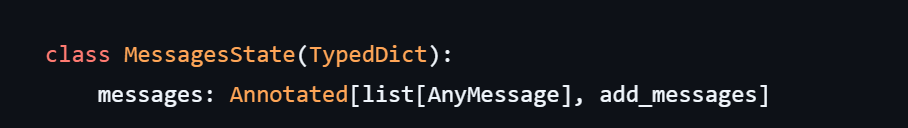

In [34]:
#class MessagesState(TypedDict):
#    messages: Annotated[list[AnyMessage], add_messages]

#### this state is a dict which containing the message as list and inside the list there could be n numbers of messages

#### this state will be flowing across all the nodes(function) in langgraph

In [22]:
def call_model(state:MessagesState):
    question=state["messages"]
    response=openai_model.invoke(question)
    return {"messages":[response]}

In [23]:
workflow=StateGraph(MessagesState)

In [24]:
workflow.add_node("chatbot",call_model)

In [25]:
workflow.add_edge(START,"chatbot")

In [26]:
workflow.add_edge("chatbot",END)

In [27]:
app=workflow.compile()

In [28]:
from IPython.display import Image,display

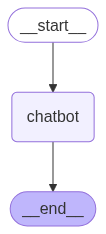

In [29]:
display(Image(app.get_graph().draw_mermaid_png()))

In [30]:
input={"messages":["hi my name is sunny"]}

In [31]:
response=app.invoke(input)

In [32]:
response["messages"][-1].content

'Hello Sunny! How can I assist you today?'

In [33]:
for output in app.stream(input):
    for key,value in output.items():
        print(f"Output from {key} Node")
        print("_______")
        print(value)
        print("\n")

Output from chatbot Node
_______
{'messages': [AIMessage(content='Hello, Sunny! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 12, 'total_tokens': 23, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a288987b44', 'id': 'chatcmpl-BzhNiyKDrnMxjxgTJpVdLaEmJVWG8', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--10c09222-548a-47ab-a53e-60e41885fa6b-0', usage_metadata={'input_tokens': 12, 'output_tokens': 11, 'total_tokens': 23, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}




## TOOLS:

In [34]:
@tool
def search(query:str):
    """this is a tool for weather checking"""
    if "india" in query.lower() or "delhi" in query.lower():
        return "the weather is hot with some foggy"
    return "weather is cloudy with some darkness"

In [35]:
search.invoke("what is a weather in japan?")

'weather is cloudy with some darkness'

In [36]:
search.invoke("what is a weather in delhi?")

'the weather is hot with some foggy'

In [37]:
tools=[search]

In [38]:
llm_with_tool = openai_model.bind_tools(tools)

In [39]:
response = llm_with_tool.invoke("hi")

In [40]:
response.content

'Hello! How can I assist you today?'

In [41]:
response.tool_calls

[]

In [42]:
result=llm_with_tool.invoke("what is a weather in europe?")

In [43]:
result.content

''

In [44]:
result.tool_calls

[{'name': 'search',
  'args': {'query': 'weather in Europe'},
  'id': 'call_GVHX8x5DG4hWdosNxJwyEuPA',
  'type': 'tool_call'}]

In [45]:
def call_model(state:MessagesState):
    question=state["messages"]
    response=llm_with_tool.invoke(question)
    return {"messages":[response]}

In [46]:
input={'messages': ['hi my name is sunny']}

In [47]:
response = call_model(input)

In [48]:
message = response["messages"]

In [49]:
last_message = message[-1]

In [50]:
last_message.content

'Hello Sunny! How can I assist you today?'

In [51]:
last_message.tool_calls

[]

In [52]:
input={'messages': ['what is a weather in mumbai?']}

In [53]:
response = call_model(input)

In [54]:
message = response["messages"]
last_message = message[-1]
last_message.content

''

In [55]:
last_message.tool_calls

[{'name': 'search',
  'args': {'query': 'weather in Mumbai'},
  'id': 'call_cH4PPUbGeyaeA1Uj0Lg3Bd5s',
  'type': 'tool_call'}]

In [56]:
def router_function(state: MessagesState):
    message=state["messages"]
    last_message=message[-1]
    if last_message.tool_calls:
        return "tools"
    return END

In [57]:
tools

[StructuredTool(name='search', description='this is a tool for weather checking', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x0000022C1B852980>)]

In [58]:
tool_node = ToolNode(tools)

In [59]:
workflow = StateGraph(MessagesState)

In [60]:
workflow.add_node("assistant",call_model)
workflow.add_node("myweathertool",tool_node)

In [61]:
workflow.add_edge(START, "assistant")

workflow.add_conditional_edges("assistant",
                               router_function,
                               {"tools": "myweathertool", END: END})

app = workflow.compile()

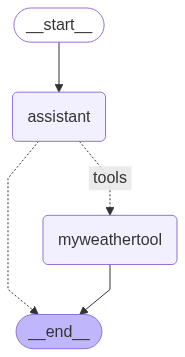

In [62]:
display(Image(app.get_graph().draw_mermaid_png()))

In [63]:
app.invoke({"messages": ["how are you?"]})

{'messages': [HumanMessage(content='how are you?', additional_kwargs={}, response_metadata={}, id='173beead-f36a-40a7-a7b7-df4b5532cda4'),
  AIMessage(content="I'm just a computer program, so I don't have feelings, but I'm here and ready to assist you! How can I help you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 48, 'total_tokens': 77, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a288987b44', 'id': 'chatcmpl-BzhOTqog1pGLQOmZzkjdneCnaeo59', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--46a2e8f4-19c7-484a-8aad-8137f458449c-0', usage_metadata={'input_tokens': 48, 'output_tokens': 29, 'total_tokens': 77, 'input_token_details': {'audio': 0, 'cache_read': 0}, '

In [64]:
query1 = app.invoke({"messages": ["how are you?"]})
query1["messages"][-1].content

"I'm just a virtual assistant, so I don't have feelings, but I'm here to help you! How can I assist you today?"

In [65]:
app.invoke({"messages": ["what is a weather in delhi?"]})

{'messages': [HumanMessage(content='what is a weather in delhi?', additional_kwargs={}, response_metadata={}, id='b5fec27a-2718-4ad4-911a-8939cc9c9fa8'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ZUmTbPAXyQBPLzBBdq2Gbuo1', 'function': {'arguments': '{"query":"Delhi weather"}', 'name': 'search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 52, 'total_tokens': 66, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a288987b44', 'id': 'chatcmpl-BzhOXcaeu61ApRE2QFP7pBtk5CY6s', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--3de163b6-0e99-44c5-b66c-d0ad9c90fcaf-0', tool_calls=[{'name': 'search', 'args': {'query': 'Delhi weather'}, 'id': 'call

In [66]:
query2 = app.invoke({"messages": ["what is a weather in delhi?"]})
query2["messages"][-1].content

'the weather is hot with some foggy'

In [67]:
workflow.add_edge("myweathertool","assistant")  

Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


In [68]:
app = workflow.compile()

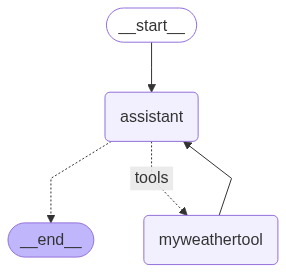

In [69]:
display(Image(app.get_graph().draw_mermaid_png()))

In [70]:
app.invoke({"messages": ["what is a weather in delhi?"]})

{'messages': [HumanMessage(content='what is a weather in delhi?', additional_kwargs={}, response_metadata={}, id='130cc99a-243b-486a-875a-12cc60b9fd6b'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_rYwpIp62BUHAp9qsu1VJKpQz', 'function': {'arguments': '{"query":"current weather in Delhi"}', 'name': 'search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 52, 'total_tokens': 68, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a288987b44', 'id': 'chatcmpl-BzhOfaC4R2TxNcG2wvfh0w2vzdHsj', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--e6c77a86-c1f6-4885-8383-1e427d69538d-0', tool_calls=[{'name': 'search', 'args': {'query': 'current weather i

In [71]:
for output in app.stream({"messages": ["what is the weather in delhi"]}):
    for key,value in output.items():
        print(f"here is output from {key}")
        print("_______")
        print(value)
        print("\n")

here is output from assistant
_______
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ZWkw2NxMeG8lyyydTAz632sA', 'function': {'arguments': '{"query":"Delhi weather"}', 'name': 'search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 51, 'total_tokens': 65, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a288987b44', 'id': 'chatcmpl-BzhOiOQWc2pYeZZWH2OCuVBg29oYu', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--8a4e9c28-d0c7-4408-ba29-86a4329aa3fd-0', tool_calls=[{'name': 'search', 'args': {'query': 'Delhi weather'}, 'id': 'call_ZWkw2NxMeG8lyyydTAz632sA', 'type': 'tool_call'}], usage_metadata={'input_tokens': 51, 'output_tokens': 

## Next Tool:

In [72]:
@tool
def multiply(a:int,b:int)->int:
    """multiply a and b"""
    return a*b

In [73]:
@tool
def add(a:int,b:int)->int:
    """adding two numbers a and b"""
    return a+b

In [74]:
@tool
def divide(a:int,b:int)->int:
    """dividing two numbers a and b"""
    return a/b

In [75]:
@tool
def subtract(a:int,b:int)->int:
    """subtracting two numbers a and b """
    return a-b

In [76]:
from langchain_community.tools import DuckDuckGoSearchRun


In [77]:
duckduckgo_search = DuckDuckGoSearchRun()

In [79]:
duckduckgo_search.invoke("who is a current prime minister of USA??")

c:\Users\souma\anaconda3\envs\rag\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:63: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:


'Terms and conditions apply. When you buy or sell cryptocurrency, a difference between the current market price and the price you buy or sell that asset for is called a … An electric current is a flow of charged particles, such as electrons or ions, moving through an electrical conductor or space. It is defined as the net rate of flow of … Current is a measure of how much electric charge flows through a circuit. The more charge that flows, the bigger the current. Real‑time electricity generation, demand, and carbon intensity data for Great Britain, updated every 5–30 minutes. View the full generation mix or focus on renewables, … Current is sometimes confused with electric potential or voltage, but a voltage difference between two points (such as the two terminals of a battery) means only that …'

#### Toolkit:

In [80]:
tools = [multiply, add, divide, subtract, duckduckgo_search]

BIND_TOOLS: https://python.langchain.com/api_reference/openai/chat_models/langchain_openai.chat_models.base.ChatOpenAI.html

In [81]:
llm_with_tools = openai_model.bind_tools(tools)

In [82]:
llm_with_tools

RunnableBinding(bound=ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x0000022C1B07D940>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x0000022C1B07E3C0>, root_client=<openai.OpenAI object at 0x0000022C1AEFEA50>, root_async_client=<openai.AsyncOpenAI object at 0x0000022C1B07E120>, model_name='gpt-4o', model_kwargs={}, openai_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'multiply', 'description': 'multiply a and b', 'parameters': {'properties': {'a': {'type': 'integer'}, 'b': {'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'add', 'description': 'adding two numbers a and b', 'parameters': {'properties': {'a': {'type': 'integer'}, 'b': {'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'divide', 'description': 'dividing two numbers a and b', 

In [83]:
llm_with_tools.invoke("hi").tool_calls

[]

In [84]:
llm_with_tools.invoke("can you add these two number 5 and 40?").tool_calls

[{'name': 'add',
  'args': {'a': 5, 'b': 40},
  'id': 'call_hDLRYpjhkfw6Iwv86mAtt3kO',
  'type': 'tool_call'}]

In [85]:
llm_with_tools.invoke("can you multiply these two number 5 and 40?").tool_calls

[{'name': 'multiply',
  'args': {'a': 5, 'b': 40},
  'id': 'call_0BVmY6m9YEeZzYyXVHXAU4qI',
  'type': 'tool_call'}]

In [86]:
llm_with_tools.invoke("can you divide these two number 5 and 40?").tool_calls

[{'name': 'divide',
  'args': {'a': 5, 'b': 40},
  'id': 'call_dQDUnOqLWzEPClpACoIeJyoT',
  'type': 'tool_call'}]

In [87]:
llm_with_tools.invoke("what is a current gdp of india with current affaires").tool_calls

[{'name': 'duckduckgo_search',
  'args': {'query': 'current GDP of India 2023'},
  'id': 'call_zcwI3uVYpXkM4fls5VNidVvr',
  'type': 'tool_call'}]

In [88]:
from langchain_core.messages import HumanMessage, SystemMessage

In [89]:
# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with using search and performing arithmetic on a set of inputs.")
     

## Creating Assistant:

In [90]:
def assistant(state:MessagesState):
    return {"messages":[llm_with_tools.invoke([sys_msg]+state["messages"])]}

## Workflow:

In [91]:
builder = StateGraph(MessagesState)

In [92]:
builder.add_node("assistant",assistant)

In [93]:
builder.add_node("tools",ToolNode(tools))

In [94]:
builder.add_edge(START,"assistant")

In [95]:

from langgraph.prebuilt import tools_condition

In [96]:
builder.add_conditional_edges(
    "assistant",
    tools_condition
)

In [97]:
react_app = builder.compile()

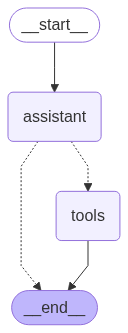

In [98]:
display(Image(react_app.get_graph().draw_mermaid_png()))

In [99]:
builder.add_edge("tools","assistant")

Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


In [100]:
react_app = builder.compile()

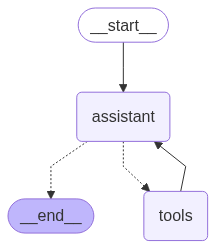

In [101]:
display(Image(react_app.get_graph().draw_mermaid_png()))

In [102]:
message = [HumanMessage(content="what is twice of narendra modi's current age?")]

#### This below detail is called a Agentic Flow:
- first it will come to assistant
- then it will search narendra modi age
- then it will come to again assistant
- then it wil call the multiply tool for getting twice of age
- then again it will come to assistant 
- then it will generate a final answer

#### REACT WORKFLOW:
#### REACT->> Reasoning+actions

- Thinking, action, observation, thiniking,action, observation---> if everything is going to be fullfill
- then generating a final ans

In [103]:
response = react_app.invoke({"messages":message})

c:\Users\souma\anaconda3\envs\rag\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:63: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:
c:\Users\souma\anaconda3\envs\rag\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:63: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:
c:\Users\souma\anaconda3\envs\rag\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:63: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:


In [104]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

what is twice of narendra modi's current age?
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (call_gGESqlTq4ZKzvrkRPUL3kTZj)
 Call ID: call_gGESqlTq4ZKzvrkRPUL3kTZj
  Args:
    query: Narendra Modi current age
================================= Tool Message =================================
Name: duckduckgo_search

1 day ago · A list of recent death notices for Cork, Ireland. Click on any entry to view the full death notice and add your condolences. Find death and funeral notices from Cork, as well as in memoriams and acknowledgements. RIP.ie Cork - death notices for County Cork, Ireland. Jan 9, 2025 · RUTH CAHILL (nee O’Connell) Youghal and late of Ballyshane and Douglas Road Cork. On March 16th 2025 passed away peacefully at Marymount University Hospital and Hospice surrounded by her loving… Nov 10, 2017 · CASEY - Dr. Pat (Millstreet, Co. 

In [105]:
messages = [HumanMessage(content="hi hello how are you?")]

In [106]:
response = react_app.invoke({"messages":messages})

In [107]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

hi hello how are you?
================================== Ai Message ==================================

Hello! I'm here to help you with any questions or tasks you have. How can I assist you today?


In [108]:
messages=[HumanMessage(content="what is current gdp of china and india can you give me difference between them?")]

1. humanmessage
2. ai mesage:toolcall
3. duckcuk
4. ai assistant
5. sustract
6. ai
7. final answer

In [109]:
response = react_app.invoke({"messages":messages})

c:\Users\souma\anaconda3\envs\rag\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:63: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:
c:\Users\souma\anaconda3\envs\rag\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:63: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:
c:\Users\souma\anaconda3\envs\rag\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:63: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:
c:\Users\souma\anaconda3\envs\rag\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:63: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:


In [110]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

what is current gdp of china and india can you give me difference between them?
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (call_Fuk8LAbE7J8qpaNGEWK0WwVU)
 Call ID: call_Fuk8LAbE7J8qpaNGEWK0WwVU
  Args:
    query: current GDP of China 2023
  duckduckgo_search (call_p3hTpg5swYfMjhg2upslgriY)
 Call ID: call_p3hTpg5swYfMjhg2upslgriY
  Args:
    query: current GDP of India 2023
================================= Tool Message =================================
Name: duckduckgo_search

2 days ago · Countries are sorted by nominal GDP estimates from financial and statistical institutions, which are calculated at market or government official exchange rates. Dec 26, 2024 · Gross domestic product (GDP) in 2023 was raised by 3.4 trillion yuan to 129.4 trillion ($17.73 trillion), Kang Yi, the head of the National Bureau of Statistics, told a presss 

As of 2023, China's GDP is approximately $17.73 trillion, while India's GDP is about $3.9 trillion. The difference in their GDPs is approximately $13.83 trillion, with China's economy being larger than India's by this amount.

project: rag,agent,deployment,modular coding,ci/cd,git

multiagentic system -> collabrative agent and supervisor agent

#### Reaserch and analsysis react agent: Assisgnment:

1. llm assistant
2. take a realtime weather api to check the real time weather detail
3. take a realtime api for checking realtime cricket score
4. take a tool for analysis the generated data (REPL) python code
5. create a report based on the generated data

memory

human in loop

multiagentic flow


from next week onwards will implemnt the project

## 1. Langgraph -> Memeory Saver, Human In Loop:


In [10]:
from typing import Annotated
import operator,json
from typing import TypedDict, Annotated, Sequence
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph,END,START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults

TAVILY_API_KEY: https://app.tavily.com/home 

In [11]:
import os
from langchain_community.tools.tavily_search import TavilySearchResults
TAVILY_API_KEY="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"
os.environ["TAVILY_API_KEY"]=TAVILY_API_KEY

In [12]:
import os
os.environ["TAVILY_API_KEY"]=TAVILY_API_KEY

In [13]:
@tool
def multiply(first_number:int, second_number:int)->int:
    """multiply two integer number"""
    return first_number * second_number

In [14]:
@tool
def search(query:str):
    """perform the web search on the user query"""
    tavily=TavilySearchResults(tavily_api_key="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")
    result=tavily.invoke(query)
    return result
     

In [15]:
search.invoke("who is a current PM in india?")

[{'title': 'Prime Minister of India - Wikipedia',
  'url': 'https://en.wikipedia.org/wiki/Prime_Minister_of_India',
  'content': 'Rao, Atal Bihari Vajpayee, Manmohan Singh, and Narendra Modi, who is the current prime minister of India, serving since 26 May 2014. He is the first non-Congress leader to win three consecutive general elections and secure a third successive term (2014, 2019, 2024). The first prime minister to do so was Jawaharlal Nehru, who won the general elections of 1952, 1957, and 1962. [...] | Prime Minister of the Republic of India | |\n| --- | --- |\n| Bhārata kē Pradhānamantrī | |\n| Logo of the Prime Minister of India | |\n| Flag of India | |\n| Incumbent Narendra Modi since 26 May 2014 | |\n| Prime Minister\'s Office "Prime Minister\'s Office (India)") Union Council of Ministers Executive branch of the Indian Government | |\n| Style "Style (form of address)") |  The Honourable  Mr. Prime Minister (informal)  His Excellency (diplomatic) |\n| Type | Head of governme

In [16]:
tools=[search,multiply]

In [17]:
model_with_tools=openai_model.bind_tools(tools)

In [18]:
model_with_tools.invoke("who is a cuurent pm of japan?")

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_G3m2ruRj0OuAIFYHNS0NuPKD', 'function': {'arguments': '{"query":"current Prime Minister of Japan"}', 'name': 'search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 78, 'total_tokens': 95, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a288987b44', 'id': 'chatcmpl-BzhnE6ALoIg26HwlPCzlFFn7eX1Te', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--dd56d394-f9e8-45ea-aace-0e8a0a2499dd-0', tool_calls=[{'name': 'search', 'args': {'query': 'current Prime Minister of Japan'}, 'id': 'call_G3m2ruRj0OuAIFYHNS0NuPKD', 'type': 'tool_call'}], usage_metadata={'input_tokens': 78, 'output_tokens': 17, 'total_token

In [19]:
model_with_tools.invoke("who is a cuurent pm of japan?").tool_calls

[{'name': 'search',
  'args': {'query': 'current Prime Minister of Japan'},
  'id': 'call_X1LpdNTeb4OH1lgo86X2jYTd',
  'type': 'tool_call'}]

In [20]:
tool_mapping = {tool.name: tool for tool in tools}

In [21]:
tool_mapping

{'search': StructuredTool(name='search', description='perform the web search on the user query', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x00000128FF7CC220>),
 'multiply': StructuredTool(name='multiply', description='multiply two integer number', args_schema=<class 'langchain_core.utils.pydantic.multiply'>, func=<function multiply at 0x0000012882D43100>)}

In [22]:
response = model_with_tools.invoke("who is a current president of uk?")

In [23]:
response

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_1ha8m3bHhOtnHAQMPKSCRYtt', 'function': {'arguments': '{"query":"current president of UK 2023"}', 'name': 'search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 77, 'total_tokens': 96, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a288987b44', 'id': 'chatcmpl-BzhnJpay28kii57B3WCaqnwxSoNox', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--d530bdd9-cc7f-4659-984a-1b14210cca15-0', tool_calls=[{'name': 'search', 'args': {'query': 'current president of UK 2023'}, 'id': 'call_1ha8m3bHhOtnHAQMPKSCRYtt', 'type': 'tool_call'}], usage_metadata={'input_tokens': 77, 'output_tokens': 19, 'total_tokens': 96

In [24]:
tool_details = response.additional_kwargs

In [25]:
tool_details

{'tool_calls': [{'id': 'call_1ha8m3bHhOtnHAQMPKSCRYtt',
   'function': {'arguments': '{"query":"current president of UK 2023"}',
    'name': 'search'},
   'type': 'function'}],
 'refusal': None}

In [26]:
tool_details = tool_details.get("tool_calls")

In [27]:
tool_details[0]["function"]["name"]

'search'

In [28]:
tool_details[0]["function"]["arguments"]

'{"query":"current president of UK 2023"}'

In [29]:
json.loads(tool_details[0]["function"]["arguments"])

{'query': 'current president of UK 2023'}

In [30]:
tool_mapping[tool_details[0]["function"]["name"]].invoke(json.loads(tool_details[0]["function"]["arguments"]))

[{'title': 'Rishi Sunak | Biography, Wife, Politics, & Net Worth - Britannica',
  'url': 'https://www.britannica.com/biography/Rishi-Sunak',
  'content': 'In November 2023 Sunak sacked controversial home secretary Suella Braverman as part of a broader cabinet reshuffle that saw the stunning return to government of former prime minister David Cameron as foreign secretary. Cameron, who was elevated to the House of Lords and created Lord Cameron of Chipping Norton in order to take his seat in the cabinet, seemed an unusual choice, as Sunak had previously endeavored to characterize his government as a break with the past. The return of Cameron to [...] In March 2023 Sunak held off a Tory rebellion and passed the so-called Windsor Framework, a post-Brexit deal to regulate trade between Northern Ireland, the rest of the United Kingdom, and the European Union. During his campaign to drum up support for the bill, Sunak stressed the “privileged access, not just to the U.K. home market, which is

In [31]:
tool_mapping={tool.name: tool for tool in tools}

In [32]:
tool_mapping

{'search': StructuredTool(name='search', description='perform the web search on the user query', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x00000128FF7CC220>),
 'multiply': StructuredTool(name='multiply', description='multiply two integer number', args_schema=<class 'langchain_core.utils.pydantic.multiply'>, func=<function multiply at 0x0000012882D43100>)}

In [33]:
class AgentState(TypedDict):
    messages:Annotated[Sequence[BaseMessage], operator.add]

In [34]:
def invoke_model(state:AgentState):
    messages = state['messages']
    question = messages[-1]   ## Fetching the user question
    return {"messages":[model_with_tools.invoke(question)]}

In [35]:
def invoke_tool(state:AgentState):
    print("****my state*****")
    print(state['messages'][-1])
    tool_details= state['messages'][-1].additional_kwargs.get("tool_calls", [])[0]
    
    if tool_details is None:
        raise Exception("no tool call found")
    
    print(f'Selected tool: {tool_details.get("function").get("name")}')
    
    if tool_details.get("function").get("name")=="search":
        print("**********tool detils****")
        print(tool_details)
        response = input(prompt=f"[y/n] continue with expensive web search?")
        if response == "n":
            raise Exception("web search discard")
        
    response = tool_mapping[tool_details['function']['name']].invoke(json.loads(tool_details.get("function").get("arguments")))
    return {"messages" : [response]}
     

In [36]:
def router(state:AgentState):
    tool_calls = state['messages'][-1].additional_kwargs.get("tool_calls", [])
    if len(tool_calls):
        return "tool"
    else:
        return "end"
     

In [60]:
graph=StateGraph(AgentState)

In [61]:
graph.add_node("ai_assistant",invoke_model)
graph.add_node("tool",invoke_tool)

In [62]:
graph.add_conditional_edges("ai_assistant",
                            router,
                            {"tool":"tool",
                             "end":END})

In [63]:
graph.add_edge("tool", END)

# graph.add_edge("tool", "ai_assistant")

graph.set_entry_point("ai_assistant")

In [64]:
app=graph.compile()

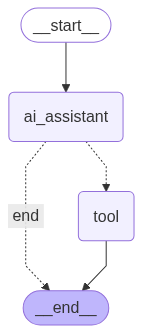

In [65]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [66]:
app.invoke({"messages": ["who is upcoming president of USA?"]})

****my state*****
content='' additional_kwargs={'tool_calls': [{'id': 'call_BChpuUfJ6m3cifbGXgIq5KZU', 'function': {'arguments': '{"query":"upcoming president of USA 2023"}', 'name': 'search'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 76, 'total_tokens': 96, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a288987b44', 'id': 'chatcmpl-BzhsijI5uxG5d1YqrFpIuT1G5Xbf6', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None} id='run--614a7b8f-4e2b-4057-9474-c98b5db1eb76-0' tool_calls=[{'name': 'search', 'args': {'query': 'upcoming president of USA 2023'}, 'id': 'call_BChpuUfJ6m3cifbGXgIq5KZU', 'type': 'tool_call'}] usage_metadata={'input_tokens': 76, 'output_tokens': 20, 'total_toke

{'messages': ['who is upcoming president of USA?',
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_BChpuUfJ6m3cifbGXgIq5KZU', 'function': {'arguments': '{"query":"upcoming president of USA 2023"}', 'name': 'search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 76, 'total_tokens': 96, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a288987b44', 'id': 'chatcmpl-BzhsijI5uxG5d1YqrFpIuT1G5Xbf6', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--614a7b8f-4e2b-4057-9474-c98b5db1eb76-0', tool_calls=[{'name': 'search', 'args': {'query': 'upcoming president of USA 2023'}, 'id': 'call_BChpuUfJ6m3cifbGXgIq5KZU', 'type': 'tool_call'}], usage_metadata={'i

In [67]:
for s in app.stream({"messages": ["who is upcoming president of USA?"]}):
    print(list(s.values())[0])
    print("----")

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_X25smEnFJA1BvRlgK1fWba03', 'function': {'arguments': '{"query":"upcoming president of USA 2024"}', 'name': 'search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 76, 'total_tokens': 96, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a288987b44', 'id': 'chatcmpl-BzhtjZPplWFgvRLqCxyNruSCCQNpg', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--86a4bb4c-2707-44ba-bd13-a8e9a6592ac5-0', tool_calls=[{'name': 'search', 'args': {'query': 'upcoming president of USA 2024'}, 'id': 'call_X25smEnFJA1BvRlgK1fWba03', 'type': 'tool_call'}], usage_metadata={'input_tokens': 76, 'output_tokens': 20, 

In [68]:
app.invoke({"messages": ["what is multiplication of 23 and 46?"]})

****my state*****
content='' additional_kwargs={'tool_calls': [{'id': 'call_akd20opvKUscX6mL9UNOPrkL', 'function': {'arguments': '{"first_number":23,"second_number":46}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 79, 'total_tokens': 98, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a288987b44', 'id': 'chatcmpl-Bzhufh82PqI7kWt4djR019V5O4OTy', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None} id='run--ec243643-034f-4f26-9489-b6dc206c02d8-0' tool_calls=[{'name': 'multiply', 'args': {'first_number': 23, 'second_number': 46}, 'id': 'call_akd20opvKUscX6mL9UNOPrkL', 'type': 'tool_call'}] usage_metadata={'input_tokens': 79, 'output_tokens': 19, 'total_tokens

{'messages': ['what is multiplication of 23 and 46?',
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_akd20opvKUscX6mL9UNOPrkL', 'function': {'arguments': '{"first_number":23,"second_number":46}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 79, 'total_tokens': 98, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a288987b44', 'id': 'chatcmpl-Bzhufh82PqI7kWt4djR019V5O4OTy', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--ec243643-034f-4f26-9489-b6dc206c02d8-0', tool_calls=[{'name': 'multiply', 'args': {'first_number': 23, 'second_number': 46}, 'id': 'call_akd20opvKUscX6mL9UNOPrkL', 'type': 'tool_call'}], usage_metadata={'

In [70]:
app.invoke({"messages": ["what is today's cricket match score?"]})

****my state*****
content='' additional_kwargs={'tool_calls': [{'id': 'call_1L27TLzpDwzZRpeYFxMxG6JG', 'function': {'arguments': '{"query":"today\'s cricket match score"}', 'name': 'search'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 76, 'total_tokens': 93, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a288987b44', 'id': 'chatcmpl-BzhvnTlT79MEC7rhPuUmejFKrmdLB', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None} id='run--cfcab8b5-ba56-4d3d-a1ee-a715b5025ab4-0' tool_calls=[{'name': 'search', 'args': {'query': "today's cricket match score"}, 'id': 'call_1L27TLzpDwzZRpeYFxMxG6JG', 'type': 'tool_call'}] usage_metadata={'input_tokens': 76, 'output_tokens': 17, 'total_tokens': 

{'messages': ["what is today's cricket match score?",
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_1L27TLzpDwzZRpeYFxMxG6JG', 'function': {'arguments': '{"query":"today\'s cricket match score"}', 'name': 'search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 76, 'total_tokens': 93, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a288987b44', 'id': 'chatcmpl-BzhvnTlT79MEC7rhPuUmejFKrmdLB', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--cfcab8b5-ba56-4d3d-a1ee-a715b5025ab4-0', tool_calls=[{'name': 'search', 'args': {'query': "today's cricket match score"}, 'id': 'call_1L27TLzpDwzZRpeYFxMxG6JG', 'type': 'tool_call'}], usage_metadata={'inp

## Langgraph Human In Loop Concept:

In [86]:

tavily=TavilySearchResults()
     

#### Single Tool:

In [106]:

tools = [tavily]

In [107]:
llm_with_tools = openai_model.bind_tools(tools)

In [108]:
def ai_assistant(state: AgentState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

#### MEMORY SAVER:

In [109]:
memory = MemorySaver()

In [110]:
graph_builder = StateGraph(AgentState)
graph_builder.add_node("ai_assistant", ai_assistant)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

In [111]:
graph_builder.add_edge(START, "ai_assistant")

graph_builder.add_conditional_edges(
    "ai_assistant",
    tools_condition,
)
graph_builder.add_edge("tools", "ai_assistant")

In [112]:
app2=graph_builder.compile(
    checkpointer=memory,
    interrupt_before=["tools"]
)

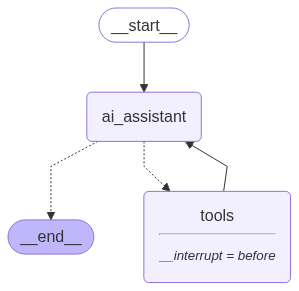

In [113]:
from IPython.display import Image, display
display(Image(app2.get_graph().draw_mermaid_png()))

In [80]:
user_input = "what is the current capital of india?"
config = {"configurable": {"thread_id": "1"}}

In [95]:
user_input = "what is today value of apple stock?"
config = {"configurable": {"thread_id": "1"}}

In [114]:
user_input = "famous places of the bangalore and must visit restaurants?"
config = {"configurable": {"thread_id": "1"}}

In [115]:
events = app2.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)

In [116]:
for event in events:
    print(event)

{'messages': [('user', 'famous places of the bangalore and must visit restaurants?')]}
{'messages': [('user', 'famous places of the bangalore and must visit restaurants?'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_LKwaaj05CufAYNRjx74E8TxV', 'function': {'arguments': '{"query": "famous places to visit in Bangalore"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_odHppkx11gaGQwooaF8VfyOw', 'function': {'arguments': '{"query": "must visit restaurants in Bangalore"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 62, 'prompt_tokens': 91, 'total_tokens': 153, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a288987b44', 'id': 'chatcmp

In [117]:
snapshot=app2.get_state(config)

In [118]:
snapshot.next

('tools',)

In [119]:

last_message=snapshot.values["messages"][-1]

In [120]:

last_message.tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'famous places to visit in Bangalore'},
  'id': 'call_LKwaaj05CufAYNRjx74E8TxV',
  'type': 'tool_call'},
 {'name': 'tavily_search_results_json',
  'args': {'query': 'must visit restaurants in Bangalore'},
  'id': 'call_odHppkx11gaGQwooaF8VfyOw',
  'type': 'tool_call'}]

In [121]:
events = app2.stream(None, config, stream_mode="values")

In [122]:
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_LKwaaj05CufAYNRjx74E8TxV)
 Call ID: call_LKwaaj05CufAYNRjx74E8TxV
  Args:
    query: famous places to visit in Bangalore
  tavily_search_results_json (call_odHppkx11gaGQwooaF8VfyOw)
 Call ID: call_odHppkx11gaGQwooaF8VfyOw
  Args:
    query: must visit restaurants in Bangalore
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "The 11 best restaurants in Bengaluru to know about", "url": "https://www.cntraveller.in/story/the-11-best-restaurants-in-bengaluru-to-know-about-top-restaurant-awards/", "content": "There’s no denying that Bengaluru is a salad bowl of all things food and brews, and a look at Condé Nast Traveller’s Top Restaurant Awards 2023 just confirms that. With 11 restaurants in the top 50, the city represented a wild mix of cuisines, cooking techniques, and innovations in fin

In [123]:
user_input = "what is the weather there?"

config = {"configurable": {"thread_id": "1"}}

In [124]:
events = app2.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)

In [125]:
for event in events:
    print(event)

{'messages': [['user', 'famous places of the bangalore and must visit restaurants?'], AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_LKwaaj05CufAYNRjx74E8TxV', 'function': {'arguments': '{"query": "famous places to visit in Bangalore"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_odHppkx11gaGQwooaF8VfyOw', 'function': {'arguments': '{"query": "must visit restaurants in Bangalore"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 62, 'prompt_tokens': 91, 'total_tokens': 153, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a288987b44', 'id': 'chatcmpl-BziR5hqhkogo8uVUkYbjDwSy0BoDc', 'service_tier': 'default', 'finish_reason': 'tool_cal

In [126]:

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

In [127]:

snapshot = app2.get_state(config)
     

In [128]:

snapshot.next

('tools',)

In [129]:

last_message=snapshot.values["messages"][-1]

In [130]:

last_message.tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'current weather in Bangalore'},
  'id': 'call_99u2JtQ8Ozp5KtbW4bQKFQCT',
  'type': 'tool_call'}]

In [131]:
events = app2.stream(None, config, stream_mode="values")

In [132]:
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_99u2JtQ8Ozp5KtbW4bQKFQCT)
 Call ID: call_99u2JtQ8Ozp5KtbW4bQKFQCT
  Args:
    query: current weather in Bangalore
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Bangalore Weather and AQI Today: Warm start at 16.5 °C, check ...", "url": "https://www.hindustantimes.com/cities/bengaluru-news/bangalore-weather-today-aqi-and-rain-forecast-updates-january-8-2025-101736299808088.html", "content": "The temperature in Bangalore today, on January 8, 2025, is 24.87 °C. The day's forecast indicates a minimum and maximum temperature of 16.5 °C and 27.25 °C,", "score": 0.9332426}, {"title": "Bangalore Weather Today (Friday, Aug 01, 2025) - India Today", "url": "https://www.indiatoday.in/weather/bangalore-weather-forecast-today", "content": "The minimum temperature in Bangalore today is likely to

In [133]:

app2.get_state(config)

StateSnapshot(values={'messages': [['user', 'famous places of the bangalore and must visit restaurants?'], AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_LKwaaj05CufAYNRjx74E8TxV', 'function': {'arguments': '{"query": "famous places to visit in Bangalore"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_odHppkx11gaGQwooaF8VfyOw', 'function': {'arguments': '{"query": "must visit restaurants in Bangalore"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 62, 'prompt_tokens': 91, 'total_tokens': 153, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a288987b44', 'id': 'chatcmpl-BziR5hqhkogo8uVUkYbjDwSy0BoDc', 'service_tier': 'default', 'fini

In [134]:
snapshot = app2.get_state(config)

In [135]:

snapshot.next

()

In [136]:
user_input = "Give me the recent news from there?"

config = {"configurable": {"thread_id": "1"}}

In [137]:
events = app2.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)

In [138]:
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

AttributeError: 'tuple' object has no attribute 'pretty_print'

In [139]:

snapshot = app2.get_state(config)
     

In [140]:

current_message = snapshot.values["messages"]
     

In [141]:
current_message

[['user', 'famous places of the bangalore and must visit restaurants?'],
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_LKwaaj05CufAYNRjx74E8TxV', 'function': {'arguments': '{"query": "famous places to visit in Bangalore"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_odHppkx11gaGQwooaF8VfyOw', 'function': {'arguments': '{"query": "must visit restaurants in Bangalore"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 62, 'prompt_tokens': 91, 'total_tokens': 153, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a288987b44', 'id': 'chatcmpl-BziR5hqhkogo8uVUkYbjDwSy0BoDc', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logpro

In [142]:
for event in events:
    if "messages" in event:
        last_message = event["messages"][-1]
        # Print the tuple elements (e.g., role and content)
        


In [143]:
current_message.pretty_print()

AttributeError: 'list' object has no attribute 'pretty_print'

In [144]:

tool_call_id = current_message.tool_calls[0]["id"] 

AttributeError: 'list' object has no attribute 'tool_calls'

In [145]:

from langchain_core.messages import AIMessage, ToolMessage

In [146]:
answer = "Delhi is too hot now a days as well as bit foggy"

In [147]:

new_messages = [
    ToolMessage(content=answer, tool_call_id=tool_call_id),
    AIMessage(content=answer),
]

NameError: name 'tool_call_id' is not defined

In [148]:

app2.update_state(
    config,
    {"messages": new_messages},
)

NameError: name 'new_messages' is not defined

In [149]:

print(app2.get_state(config).values["messages"][-1:])

[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_5K7JgECqKIHo4LzcPP8po92v', 'function': {'arguments': '{"query":"recent news in Bangalore"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 4765, 'total_tokens': 4786, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a288987b44', 'id': 'chatcmpl-BzidCEHRvR98rtOvL0fHZGUfskFQL', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--be68ee3e-76e0-44a9-be48-89e1b206e828-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'recent news in Bangalore'}, 'id': 'call_5K7JgECqKIHo4LzcPP8po92v', 'type': 'tool_call'}], usage_metadata={'input_tokens': 4765, 